In [8]:
import pandas as pd
import wget
import zipfile
import os
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, when, avg, rand, expr
from pyspark.ml.feature import VectorAssembler, StringIndexer
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import BinaryClassificationEvaluator
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Download the dataset
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00222/bank-additional.zip"
wget.download(url, "bank-additional.zip")

# Unzip the dataset
with zipfile.ZipFile("bank-additional.zip", 'r') as zip_ref:
    zip_ref.extractall()

# Load the CSV file into a Pandas DataFrame
df = pd.read_csv("bank-additional/bank-additional-full.csv", sep=';')

# Save as CSV to use with PySpark
df.to_csv("bank_marketing.csv", index=False)

-1 / unknown

In [3]:
# Initialize Spark session
spark = SparkSession.builder \
    .appName("Bank Marketing Analysis") \
    .config("spark.executor.memory", "1g") \
    .config("spark.driver.memory", "1g") \
    .getOrCreate()

# Load dataset
df = spark.read.csv("bank_marketing.csv", header=True, inferSchema=True)

# Rename columns to remove dots
for col_name in df.columns:
    new_col_name = col_name.replace('.', '_')
    df = df.withColumnRenamed(col_name, new_col_name)

# Show schema and first few rows
df.printSchema()
df.show(5)

# Data cleaning: handle missing values and correct data types
df = df.dropna()
df = df.withColumn("age", col("age").cast("integer"))

# Feature engineering: create new features or modify existing ones
df = df.withColumn("is_married", when(col("marital") == "married", 1).otherwise(0))
df = df.withColumn("has_loan", when(col("loan") == "yes", 1).otherwise(0))


24/06/04 16:58:23 WARN Utils: Your hostname, Seans-MacBook-Air.local resolves to a loopback address: 127.0.0.1; using 172.16.224.90 instead (on interface en0)
24/06/04 16:58:23 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/06/04 16:58:24 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


root
 |-- age: integer (nullable = true)
 |-- job: string (nullable = true)
 |-- marital: string (nullable = true)
 |-- education: string (nullable = true)
 |-- default: string (nullable = true)
 |-- housing: string (nullable = true)
 |-- loan: string (nullable = true)
 |-- contact: string (nullable = true)
 |-- month: string (nullable = true)
 |-- day_of_week: string (nullable = true)
 |-- duration: integer (nullable = true)
 |-- campaign: integer (nullable = true)
 |-- pdays: integer (nullable = true)
 |-- previous: integer (nullable = true)
 |-- poutcome: string (nullable = true)
 |-- emp_var_rate: double (nullable = true)
 |-- cons_price_idx: double (nullable = true)
 |-- cons_conf_idx: double (nullable = true)
 |-- euribor3m: double (nullable = true)
 |-- nr_employed: double (nullable = true)
 |-- y: string (nullable = true)

+---+---------+-------+-----------+-------+-------+----+---------+-----+-----------+--------+--------+-----+--------+-----------+------------+--------------+

24/06/04 16:58:35 WARN GarbageCollectionMetrics: To enable non-built-in garbage collector(s) List(G1 Concurrent GC), users should configure it(them) to spark.eventLog.gcMetrics.youngGenerationGarbageCollectors or spark.eventLog.gcMetrics.oldGenerationGarbageCollectors
/Users/seanfarquharson/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


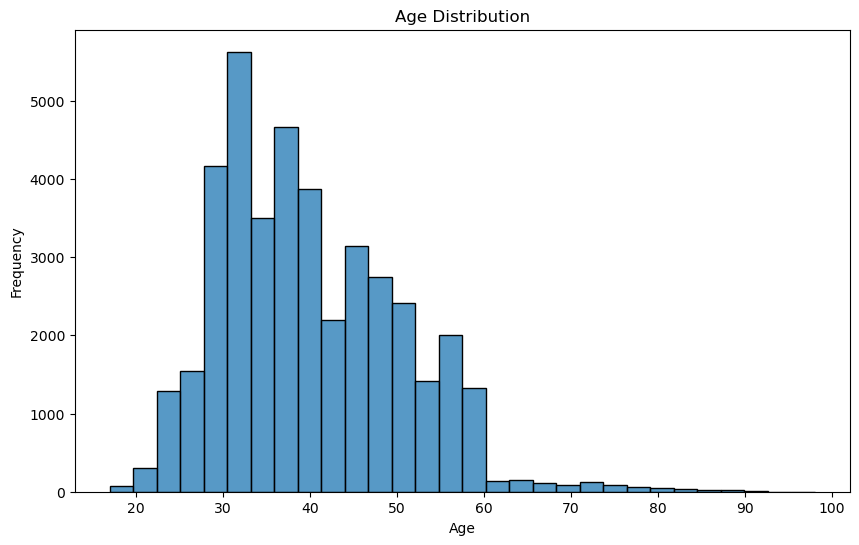

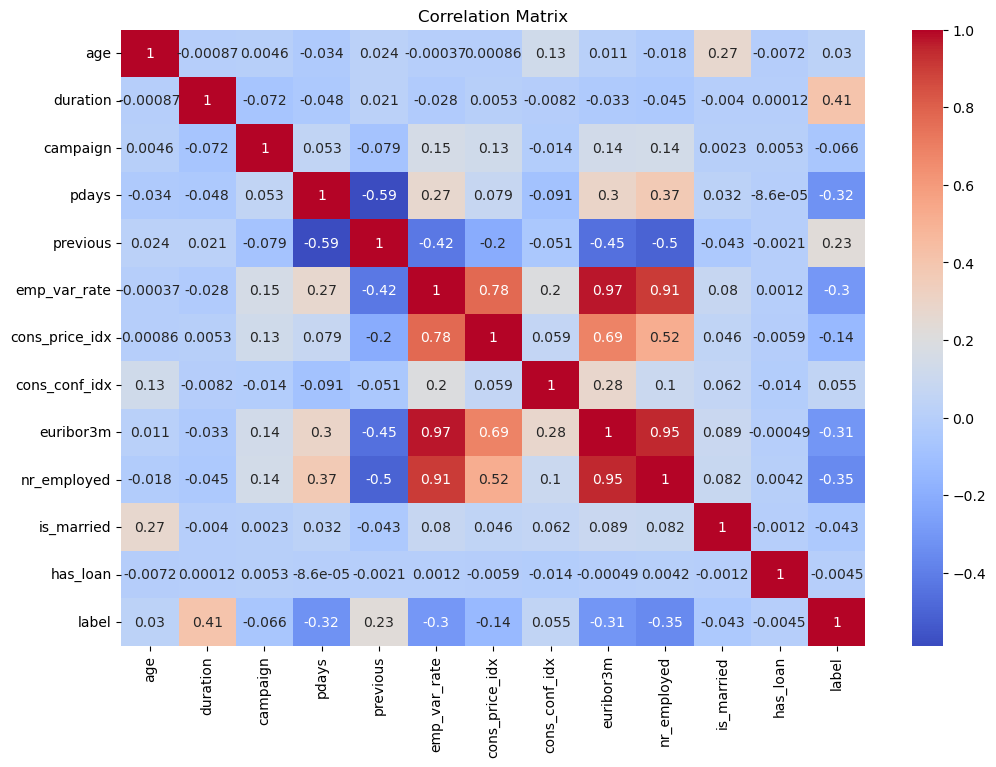

In [4]:
# Convert the label column to numeric
indexer = StringIndexer(inputCol="y", outputCol="label")
df = indexer.fit(df).transform(df)

# Convert to Pandas DataFrame for visualization
df_pd = df.toPandas()

# Plot distribution of ages
plt.figure(figsize=(10, 6))
sns.histplot(df_pd["age"], bins=30)
plt.title("Age Distribution")
plt.xlabel("Age")
plt.ylabel("Frequency")
plt.show()

# Select only numeric columns for correlation matrix
numeric_cols = df_pd.select_dtypes(include=[float, int]).columns

# Plot correlation matrix
plt.figure(figsize=(12, 8))
sns.heatmap(df_pd[numeric_cols].corr(), annot=True, cmap="coolwarm")
plt.title("Correlation Matrix")
plt.show()

In [5]:
# Prepare features and labels
assembler = VectorAssembler(inputCols=["age", "duration", "campaign", "is_married", "has_loan"], outputCol="features")
data = assembler.transform(df).select("features", col("label"))

# Split data into training and testing sets
train_data, test_data = data.randomSplit([0.8, 0.2], seed=1234)

# Train a logistic regression model
lr = LogisticRegression(labelCol="label", featuresCol="features")
lr_model = lr.fit(train_data)

# Make predictions on the test data
predictions = lr_model.transform(test_data)

# Evaluate the model
evaluator = BinaryClassificationEvaluator(labelCol="label")
accuracy = evaluator.evaluate(predictions)
print(f"Test Accuracy: {accuracy:.2f}")

24/06/04 16:58:46 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS
24/06/04 16:58:46 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.VectorBLAS


Test Accuracy: 0.83


In [9]:
# A/B Testing: Assume 'contact' column is the group identifier (e.g., 'cellular' or 'telephone')
df = df.withColumn("group", when(col("contact") == "cellular", "A").otherwise("B"))

# Calculate conversion rates
conversion_rates = df.groupBy("group").agg(expr("avg(label)").alias("conversion_rate"))

# Show conversion rates
conversion_rates.show()


+-----+-------------------+
|group|    conversion_rate|
+-----+-------------------+
|    B|0.05231321457059293|
|    A|0.14737607099143207|
+-----+-------------------+

